In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from nzdownscale.downscaler.validate_v2 import ValidateV2
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# model_name = 'hourly_1e-5_v2'
# var = 'temperature'

model_name = '240809_1e-3'
var = 'precipitation'

top_dir = '/mnt/temp/projects/DeepWeather/data_delete/DeepSensor/models'

model_dir = f'{top_dir}/{var}/{model_name}'
model_path = f'{model_dir}/{model_name}.pt'
train_metadata_path = f'{model_dir}/metadata_{model_name}.pkl'

# model_dir2 = f'/home/emily/deepsensor/deepweather-downscaling/experiments/'\
#             f'models/{var}/hourly_v2'
data_processor_path = f'{model_dir}/data_processor.pkl'
task_loader_path = f'{model_dir}/task_loader.pkl'

In [5]:
validate = ValidateV2(model_path,
                      data_processor_path,
                      task_loader_path,
                      train_metadata_path)

Producing predictions at resolution: 0.01


In [6]:
print(validate.data_processor)

DataProcessor with normalisation params:
{'TPI_0.025': {'method': 'min_max',
               'params': {'max': 157.2187957763672,
                          'min': -111.61631774902344}},
 'TPI_0.05': {'method': 'min_max',
              'params': {'max': 391.0797119140625, 'min': -265.4579772949219}},
 'TPI_0.1': {'method': 'min_max',
             'params': {'max': 767.7206420898438, 'min': -475.1228942871094}},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (-47.99512481689453, -34.005126953125),
                   'name': 'latitude'},
            'x2': {'map': (166.00486755371094, 179.994873046875),
                   'name': 'longitude'}},
 'elevation': {'method': 'min_max',
               'params': {'max': 2196.022216796875, 'min': 0.0}},
 'elevation_diff': {'method': 'min_max',
                    'params': {'max': 1835.874755859375,
                               'min': -1161.7254638671875}},
 'landmask': {'method': 'min_max', 'params': {'max': 1.0, 'min': 0.0}},
 '

In [7]:
date_range = pd.date_range(start=datetime(2016, 1, 1, 0), end=datetime(2016, 2, 1, 0), freq='H')
day = 24
time = date_range[(day * 24):((day + 1) * 24)]
time = [date.to_pydatetime() for date in time]

remove_stations_list = [
    "TAUPO AWS",
    "CHRISTCHURCH AERO",
    # "KAITAIA AERO",
    "MT COOK EWS",
    "AUCKLAND AERO",
    "ALEXANDRA AWS",
    "TOLAGA BAY WXT AWS",
    "WELLINGTON AERO",
    "BLENHEIM AERO",
    "DUNEDIN AERO AWS",
]

In [8]:
pred = validate.predict(time, remove_stations=remove_stations_list, 
                        context_sampling=['all', 'all', 'all', 0])

Loading ERA5:   0%|          | 0/6 [00:00<?, ?it/s]

Loading stations: 100%|██████████| 466/466 [01:18<00:00,  5.96it/s]


198 stations with data at prediction time(s)
Removing TAUPO AWS
Removing CHRISTCHURCH AERO
Removing MT COOK EWS
Removing AUCKLAND AERO
Removing ALEXANDRA AWS
Removing TOLAGA BAY WXT AWS
Removing WELLINGTON AERO
Removing BLENHEIM AERO
Removing DUNEDIN AERO AWS
Removed 9 stations
Pre-processing ERA5 data
Pre-processing station data
dim_yc inferred from TaskLoader: (8, 6, 1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 5
Setting aux_t_mlp_layers: (64, 64, 64)
encoder_scales inferred from TaskLoader: [0.0035739766899496317, 0.003573982510715723, 0.00035739815211854875, 0.002]
decoder_scale inferred from TaskLoader: 0.004


100%|██████████| 24/24 [01:08<00:00,  2.85s/it]


In [9]:
pred

{'precipitation_station': <xarray.Dataset>
 Dimensions:    (time: 24, latitude: 1400, longitude: 1400)
 Coordinates:
   * latitude   (latitude) float32 -48.0 -47.99 -47.98 ... -34.03 -34.02 -34.01
   * longitude  (longitude) float32 166.0 166.0 166.0 166.0 ... 180.0 180.0 180.0
   * time       (time) datetime64[ns] 2016-01-25 ... 2016-01-25T23:00:00
 Data variables:
     mean       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
     std        (time, latitude, longitude) float32 nan nan nan ... nan nan nan}

In [10]:
pred_context = validate.predict(time, remove_stations=remove_stations_list,
                                context_sampling=['all', 'all', 'all', 'all'])

Loading ERA5:   0%|          | 0/6 [00:00<?, ?it/s]

Loading stations: 100%|██████████| 466/466 [00:48<00:00,  9.68it/s]


198 stations with data at prediction time(s)
Removing TAUPO AWS
Removing CHRISTCHURCH AERO
Removing MT COOK EWS
Removing AUCKLAND AERO
Removing ALEXANDRA AWS
Removing TOLAGA BAY WXT AWS
Removing WELLINGTON AERO
Removing BLENHEIM AERO
Removing DUNEDIN AERO AWS
Removed 9 stations
Pre-processing ERA5 data
Pre-processing station data


100%|██████████| 24/24 [01:10<00:00,  2.95s/it]


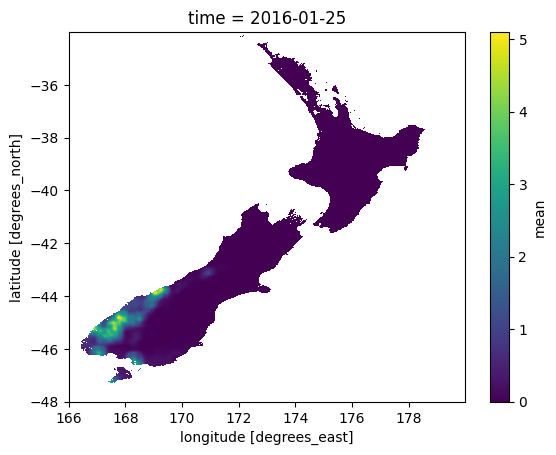

In [11]:
pred_context['precipitation_station']['mean'].isel({'time': 0}).plot()

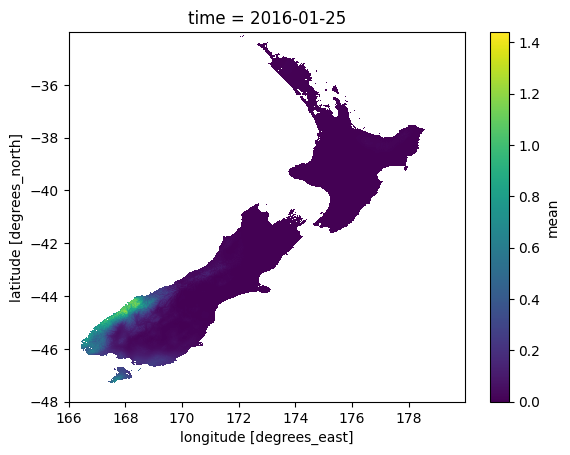

In [12]:
for i in range(1):
    fig, ax = plt.subplots()
    ds = pred[f'{var}_station']['mean']
    ds.isel(time=i).plot(ax=ax, 
                         vmax=ds.max(skipna=True), 
                         vmin=ds.min(skipna=True))

In [13]:
import xarray as xr

In [14]:
denorm_params = validate.data_processor.config[f'{var}_station']['params']
denorm_params

{'min': 0.0, 'std': 1.247752123747404}

In [15]:
task = validate.task_loader(time)
task[0]['Y_c'][0][1]
# task_era5 = task[0]['Y_c'][0][0]
# task_era5

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [16]:
# task = validate.task_loader(time)
# task_era5 = task[0]['Y_c'][0][0]
# task_era5
# # if var != 'precipitation':
# #     denorm_params = validate.data_processor.config[f'{var}_station']['params']
# #     task_era5 = (task_era5 * denorm_params['std']) + denorm_params['mean']
# # else:
# #     denorm_params = validate.data_processor.config[f'{var}_station']['params']
# # era5_ds = ds.copy()
# era5_ds = xr.DataArray(task_era5 - 273.15)
# era5_ds.plot()
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1]) 

Removed stations

In [17]:
stations_to_validate = validate.load_stations(time, keep_stations=remove_stations_list)

Loading stations:   2%|▏         | 7/466 [00:00<00:32, 14.34it/s]

Loading stations: 100%|██████████| 466/466 [00:44<00:00, 10.59it/s]

198 stations with data at prediction time(s)
Keeping TAUPO AWS
Keeping CHRISTCHURCH AERO
Keeping MT COOK EWS
Keeping AUCKLAND AERO
Keeping ALEXANDRA AWS
Keeping TOLAGA BAY WXT AWS
Keeping WELLINGTON AERO
Keeping BLENHEIM AERO
Keeping DUNEDIN AERO AWS
Kept 9 stations


In [18]:
from nzdownscale.dataprocess.config import STATION_LATLON
for station in remove_stations_list:
    print(station, STATION_LATLON[station])
    

TAUPO AWS {'station_no': '1858', 'latitude': -38.74263, 'longitude': 176.08104, 'elevation': 400.0}
CHRISTCHURCH AERO {'station_no': '4843', 'latitude': -43.493, 'longitude': 172.537, 'elevation': 37.0}
MT COOK EWS {'station_no': '18125', 'latitude': -43.736000000000004, 'longitude': 170.09599999999998, 'elevation': 730.0}
AUCKLAND AERO {'station_no': '1962', 'latitude': -37.00813, 'longitude': 174.78873000000002, 'elevation': 7.0}
ALEXANDRA AWS {'station_no': '41163', 'latitude': -45.21452, 'longitude': 169.37548999999999, 'elevation': 230.0}
TOLAGA BAY WXT AWS {'station_no': '37836', 'latitude': -38.382, 'longitude': 178.308, 'elevation': 12.0}
WELLINGTON AERO {'station_no': '3445', 'latitude': -41.321999999999996, 'longitude': 174.804, 'elevation': 4.0}
BLENHEIM AERO {'station_no': '4322', 'latitude': -41.52, 'longitude': 173.872, 'elevation': 40.0}
DUNEDIN AERO AWS {'station_no': '7339', 'latitude': -45.92675, 'longitude': 170.19683999999998, 'elevation': 1.0}


In [19]:
station_dict = {}
for station in remove_stations_list:
    station_dict[station] = {**STATION_LATLON[station]}
    station_lat = station_dict[station]['latitude']
    station_lon = station_dict[station]['longitude']

    if station_lat in stations_to_validate.index.get_level_values('latitude'):
        station_values = stations_to_validate.xs(station_lat, level='latitude')
        station_values = station_values.xs(station_lon, level='longitude')
        station_dict[station]['values'] = station_values
        print(station)
        # print(station_values)
    else:
        print(f'{station} not in stations_to_validate')
        del station_dict[station]

TAUPO AWS
CHRISTCHURCH AERO
MT COOK EWS
AUCKLAND AERO
ALEXANDRA AWS
TOLAGA BAY WXT AWS
WELLINGTON AERO
BLENHEIM AERO not in stations_to_validate
DUNEDIN AERO AWS


In [20]:
import numpy as np
from tqdm import tqdm
from scipy.interpolate import griddata

# # pred_coarse = ds.coarsen(latitude=5, longitude=5, boundary="trim").mean()
era5_var = 'precipitation'
era5_interp = validate.era5_ds_raw[era5_var].interp(
    coords={
        "latitude": ds["latitude"],
        "longitude": ds["longitude"],
    },
    method="nearest",
)
topo = validate.data_processor_dict["highres_aux_ds"]["elevation"]
topo_unnorm = validate.data_processor.unnormalise(topo)
interpolated_topo = topo_unnorm.interp_like(ds)
land_sea_mask = ~(interpolated_topo == 0)
missing_land_values = xr.where(
    land_sea_mask & np.isnan(era5_interp), True, False
)
print("Missing land values calculated")

era5_interp_filled = era5_interp.copy()
# era5_var = validate.get_variable_name('era5')
for t in tqdm(time, desc="Filling missing values"):
    era5_da = era5_interp.sel(time=t)
    valid_points = np.array(np.nonzero(~np.isnan(era5_da))).T
    valid_values = era5_da.values[~np.isnan(era5_da)]
    missing_land_values_da = missing_land_values.sel(time=t)
    invalid_points = np.array(np.nonzero(missing_land_values_da)).T
    # Perform nearest neighbor interpolation
    interpolated_values = griddata(
        valid_points, valid_values, invalid_points, method="nearest"
    )
    # Fill the era5_interp DataArray with the interpolated values
    era5_interp_filled.sel(time=t).values[tuple(invalid_points.T)] = (
        interpolated_values
    )

Missing land values calculated


Filling missing values: 100%|██████████| 24/24 [00:02<00:00, 11.82it/s]


In [21]:
lowres_topo = validate.data_processor_dict['aux_ds']['elevation']
lowres_topo = validate.data_processor.unnormalise(lowres_topo)

In [22]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [23]:
station_dict.keys()

dict_keys(['TAUPO AWS', 'CHRISTCHURCH AERO', 'MT COOK EWS', 'AUCKLAND AERO', 'ALEXANDRA AWS', 'TOLAGA BAY WXT AWS', 'WELLINGTON AERO', 'DUNEDIN AERO AWS'])

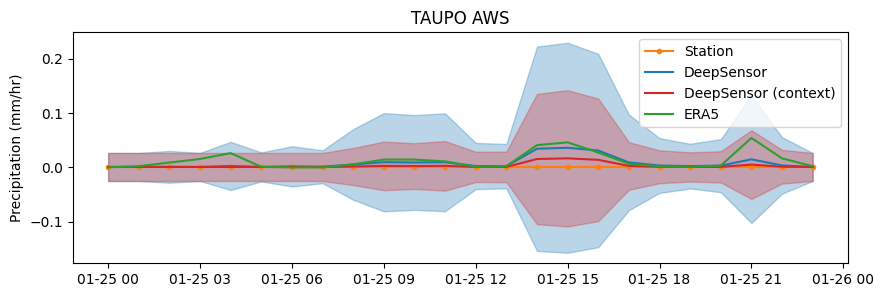

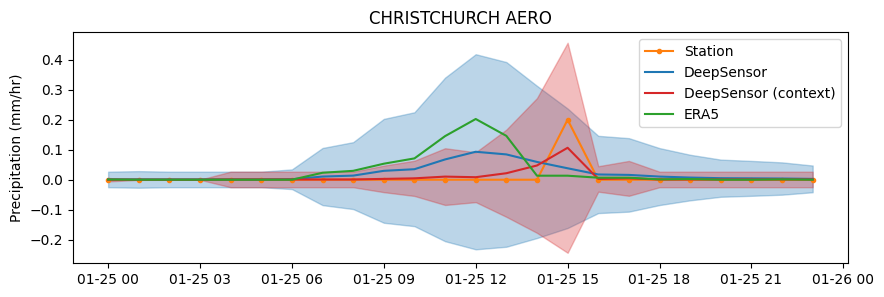

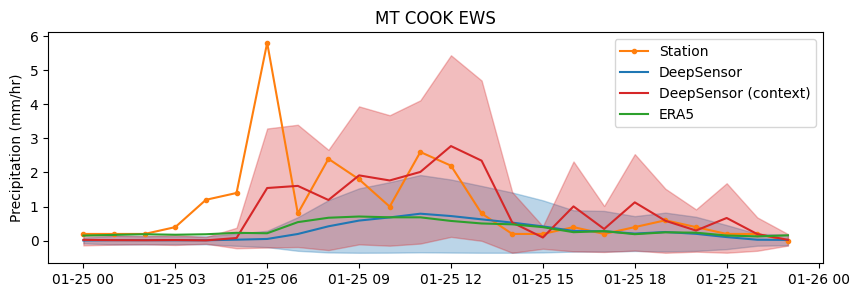

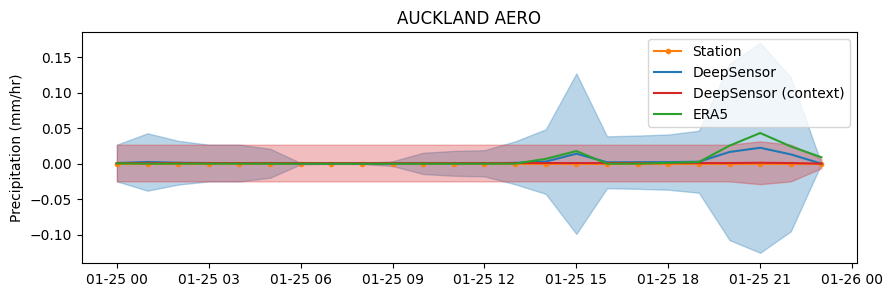

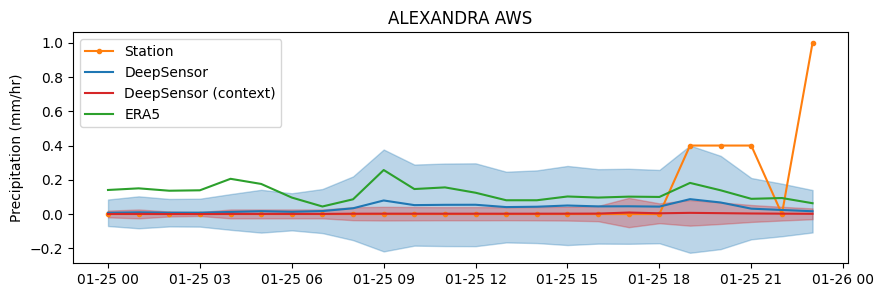

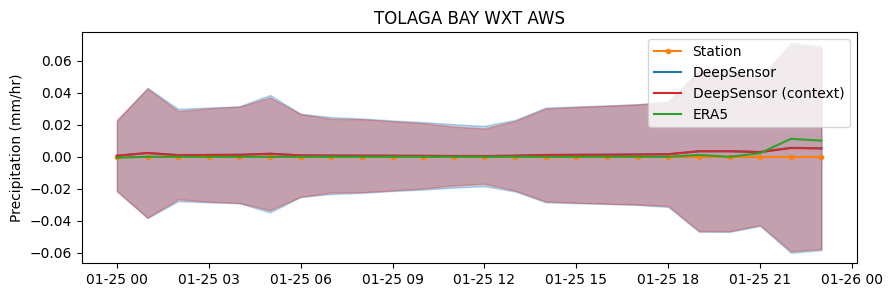

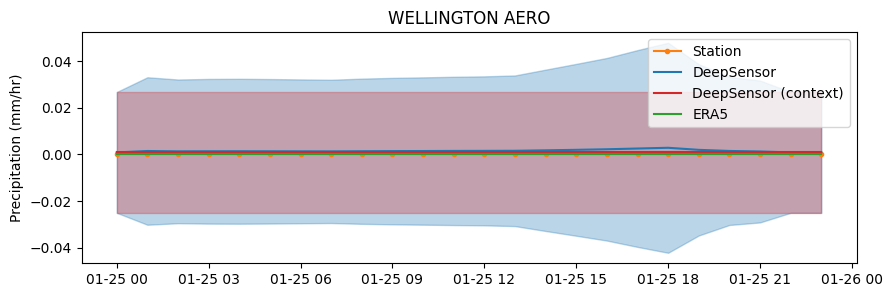

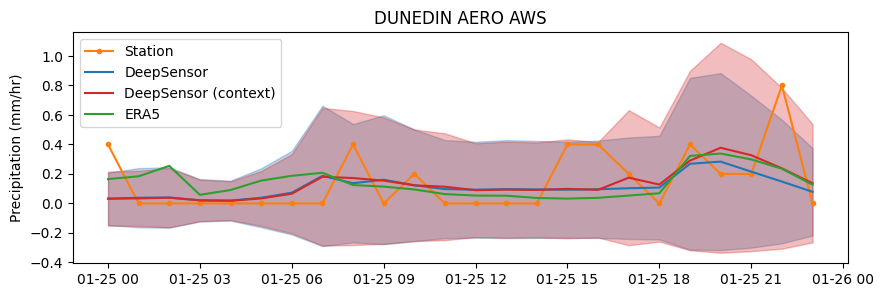

In [24]:
for station, dict_values in station_dict.items():
    fig, ax = plt.subplots(figsize=(10, 3))
    # remove duplicates
    timeseries = dict_values['values'].reset_index().drop_duplicates(subset='time').set_index('time')

    first_day = 0
    last_day = 4
    times_to_plot = time
    # times_to_plot = pred_values.time.values[(24 * first_day):(24 * last_day)]
    # times_to_plot = pred_values.time.values

    # DeepSensor
    pred_values = pred[f'{var}_station'].sel({'latitude': dict_values['latitude'], 
            'longitude': dict_values['longitude']},
            method='nearest')
    pred_context_values = pred_context[f'{var}_station'].sel({'latitude': dict_values['latitude'], 
            'longitude': dict_values['longitude']},
            method='nearest')

    timeseries['deepsensor'] = pred_values['mean']
    timeseries['deepsensor_std'] = pred_values['std']

    timeseries['deepsensor_context'] = pred_context_values['mean']
    timeseries['deepsensor_context_std'] = pred_context_values['std']

    # ERA5 
    era5 = era5_interp_filled.sel({'latitude': dict_values['latitude'], 
                                'longitude': dict_values['longitude']},
                                method='nearest')
    elevation = dict_values['elevation']
    
    if var == 'temperature':
        low_res_topo_at_location = float(lowres_topo.sel({'latitude': dict_values['latitude'],
                                                    'longitude': dict_values['longitude']},
                                                    method='nearest').values)
        print(f'{station}')
        print(f'Low res: {low_res_topo_at_location}, high res: {elevation}')
        lapse_rate = 0.0065 * (elevation - low_res_topo_at_location)
        lapse_era5 = era5 - lapse_rate
        timeseries['era5_lapse'] = lapse_era5 - 273.15 
        timeseries['era5'] = era5 - 273.15

    else:
        timeseries['era5'] = era5

    ax.plot(timeseries[f'{var}_station'].loc[times_to_plot], label='Station',
             color=colors[1], marker='o', markersize=3)
    ax.plot(timeseries['deepsensor'].loc[times_to_plot], label='DeepSensor', color=colors[0])
    ax.fill_between(times_to_plot, (timeseries['deepsensor'] - timeseries['deepsensor_std']).loc[times_to_plot], 
                    (timeseries['deepsensor'] + timeseries['deepsensor_std']).loc[times_to_plot], 
                    color=colors[0], alpha=0.3)

    ax.plot(timeseries['deepsensor_context'].loc[times_to_plot], label='DeepSensor (context)', color=colors[3])
    ax.fill_between(times_to_plot, (timeseries['deepsensor_context'] - timeseries['deepsensor_context_std']).loc[times_to_plot], 
                    (timeseries['deepsensor_context'] + timeseries['deepsensor_context_std']).loc[times_to_plot], 
                    color=colors[3], alpha=0.3)
    
    ax.plot(timeseries['era5'].loc[times_to_plot], label='ERA5', color=colors[2], )
    if var == 'temperature':
        ax.plot(timeseries['era5_lapse'].loc[times_to_plot], label=f'Lapse-rate adjusted ERA5',
            color=colors[2], linestyle='--')

    units = '°C' if var == 'temperature' else 'mm/hr'
    ax.set_ylabel(f'{var.capitalize()} ({units})')
    ax.legend()
    ax.set_title(station)

    # fig.savefig(f'/home/emily/deepsensor/deepweather-downscaling/experiments/deepsensor/emily_dev_local/paper/images/precip_timeseries/{station}_2016_Jan_01_05.pdf')
    

# Model outputs

In [25]:
import cartopy.crs as ccrs
import cartopy.feature as cf

In [26]:
plt.rcParams.update({
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 12,     # Axis label font size
    'xtick.labelsize': 12,    # X-axis tick label font size
    'ytick.labelsize': 10,    # Y-axis tick label font size
    # 'legend.fontsize': 14,    # Legend font size
    'figure.titlesize': 18    # Figure title font size
})

In [27]:
time_step = 20

stations_df = validate.stations_df_raw

time = pred[f'{var}_station'].time.values[time_step]
print('time = ', time)

min_val = pred[f'{var}_station']['mean'].isel(time=time_step).min()
max_val = max(pred[f'{var}_station']['mean'].isel(time=time_step).max(),
                validate.era5_ds_raw[era5_var].isel(time=time_step).max(),
                stations_df[f'{var}_station'].loc[time].max())

time =  2016-01-25T20:00:00.000000000


2016-01-25T20:00:00.000000000


Text(0.5, 1.0, 'ERA5-Land')

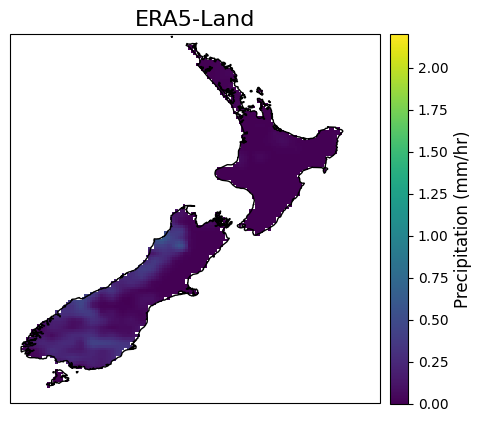

In [28]:
fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()))
cbar_kwargs = {'label': 'Precipitation (mm/hr)', 
               'pad': 0.02}

era5_t0 = validate.era5_ds_raw[era5_var].isel(time=time_step)
print(era5_t0.time.values)
# era5_t0 = era5_interp_filled.isel({'time':0})
era5_t0_c_vals = np.where(era5_t0 < 0, 0, era5_t0)
era5_t0.values = era5_t0_c_vals
era5_t0.plot(cmap='viridis', ax=ax, vmin=0, vmax=max_val,
                cbar_kwargs=cbar_kwargs)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_title('ERA5-Land')

# fig.savefig(f'/home/emily/deepsensor/deepweather-downscaling/experiments/deepsensor/emily_dev_local/paper/images/example_outputs/era5_land_precip.png',
#             bbox_inches='tight')

time =  2016-01-25T20:00:00.000000000


Text(0.5, 1.0, 'ConvNP Mean')

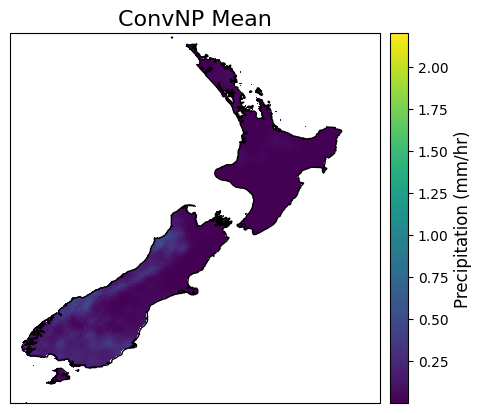

In [29]:
fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()))

# cbar_kwargs = {'label': 'Temperature (°C)',
#                'pad': 0.02}

convnp_t0 = pred[f'{var}_station'].isel({'time':time_step})['mean']
print('time = ', convnp_t0.time.values)
# era5_t0_c = era5_t0 - 273.15
convnp_t0.plot(cmap='viridis', ax=ax, vmin=min_val, vmax=max_val,
               cbar_kwargs = cbar_kwargs)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_title('ConvNP Mean')
# fig.savefig(f'/home/emily/deepsensor/deepweather-downscaling/experiments/deepsensor/emily_dev_local/paper/images/example_outputs/convnp_precip_mean.png',
#             bbox_inches='tight')


Text(0.5, 1.0, 'ConvNP Std')

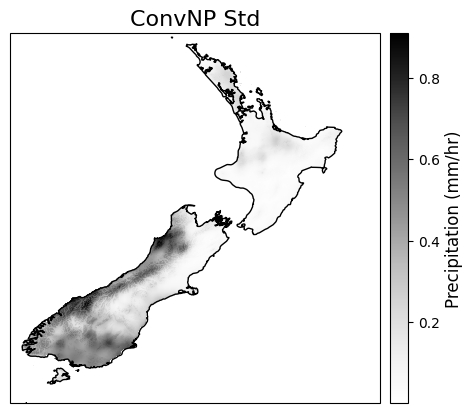

In [30]:
fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()))

# cbar_kwargs = {'label': 'Temperature (°C)',
#                'pad': 0.02}

convnp_t0 = pred[f'{var}_station'].isel({'time':time_step})['std']
# era5_t0_c = era5_t0 - 273.15
convnp_t0.plot(cmap='Greys', ax=ax, cbar_kwargs = cbar_kwargs)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_title('ConvNP Std')
# fig.savefig(f'/home/emily/deepsensor/deepweather-downscaling/experiments/deepsensor/emily_dev_local/paper/images/example_outputs/convnp_precip_std.png',
#             bbox_inches='tight')

time =  2016-01-25T20:00:00.000000000


Text(0.5, 1.0, 'ConvNP context Mean')

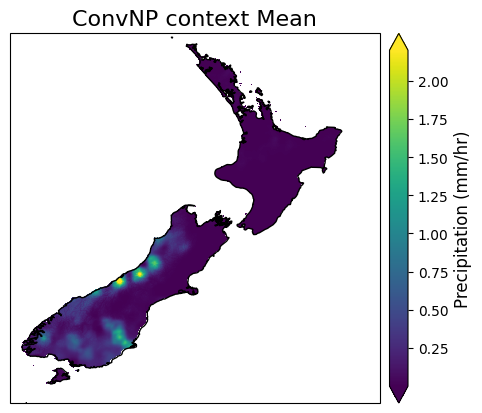

In [31]:
fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()))

# cbar_kwargs = {'label': 'Temperature (°C)',
#                'pad': 0.02}

convnp_t0 = pred_context[f'{var}_station'].isel({'time':time_step})['mean']
print('time = ', convnp_t0.time.values)
# era5_t0_c = era5_t0 - 273.15
convnp_t0.plot(cmap='viridis', ax=ax, vmin=min_val, vmax=max_val,
               cbar_kwargs = cbar_kwargs)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_title('ConvNP context Mean')
# fig.savefig(f'/home/emily/deepsensor/deepweather-downscaling/experiments/deepsensor/emily_dev_local/paper/images/example_outputs/convnp_precip_mean.png',
#             bbox_inches='tight')


Text(0.5, 1.0, 'ConvNP Std')

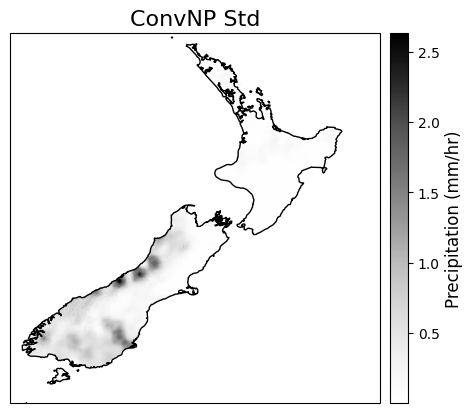

In [32]:
fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()))

# cbar_kwargs = {'label': 'Temperature (°C)',
#                'pad': 0.02}

convnp_t0 = pred_context[f'{var}_station'].isel({'time':time_step})['std']
# era5_t0_c = era5_t0 - 273.15
convnp_t0.plot(cmap='Greys', ax=ax, cbar_kwargs = cbar_kwargs)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_title('ConvNP Std')
# fig.savefig(f'/home/emily/deepsensor/deepweather-downscaling/experiments/deepsensor/emily_dev_local/paper/images/example_outputs/convnp_precip_std.png',
#             bbox_inches='tight')

time =  2016-01-25T20:00:00.000000000


Text(0.5, 1.0, 'Stations')

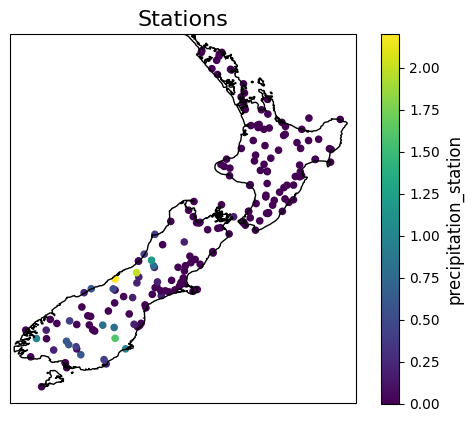

In [33]:

# for time_step in range(12, 24):
era5_t0 = validate.era5_ds_raw[era5_var].isel(time=time_step)
the_time = era5_t0.time.values
the_time

fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()))

# cbar_kwargs = {'label': 'Temperature (°C)',
#                'pad': 0.02}
stations_t0 = stations_df[stations_df.index.get_level_values('time') == the_time]
print('time = ', the_time)
stations_t0 = stations_t0.reset_index()
stations_t0.plot.scatter(x='longitude', y='latitude', c='precipitation_station', cmap='viridis', ax=ax,
                        vmin=0,)# vmax=max_val,)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_title('Stations')
# fig.savefig(f'/home/emily/deepsensor/deepweather-downscaling/experiments/deepsensor/emily_dev_local/paper/images/example_outputs/convnp_precip_std.png',
        # bbox_inches='tight')

In [37]:
convnp_list = []
era5_list = []
convnp_context = []

for _, row in tqdm(stations_df.iterrows(), total=stations_df.shape[0]):
    time, lat, lon = row.name  # Assuming the index contains these values
    convnp_value = pred[f'{var}_station'].sel({'latitude': lat, 'longitude': lon, 'time': time}, method='nearest')['mean'].values
    era5_value = era5_interp_filled.sel({'latitude': lat, 'longitude': lon, 'time': time}, method='nearest').values
    convnp_context_value = pred_context[f'{var}_station'].sel({'latitude': lat, 'longitude': lon, 'time': time}, method='nearest')['mean'].values
    
    convnp_list.append(convnp_value)
    era5_list.append(era5_value)
    convnp_context.append(convnp_context_value)

# Add the new columns to the dataframe
stations_df['convnp'] = convnp_list
stations_df['era5'] = era5_list
stations_df['convnp_context'] = convnp_context


  4%|▍         | 182/4576 [00:00<00:09, 466.94it/s]

100%|██████████| 4576/4576 [00:09<00:00, 483.74it/s]


In [38]:
stations_df

precipitation_station        convnp  \
time                latitude  longitude                                        
2016-01-25 00:00:00 -47.27675 167.46290                    2.6    0.43384373   
                    -46.58700 168.37600                    3.2    0.19425482   
                    -46.44900 169.81000                    0.0    0.17112266   
                    -46.41727 168.33045                    2.8     0.1758704   
                    -46.41104 168.31779                    2.4    0.16919085   
...                                                        ...           ...   
2016-01-25 23:00:00 -35.26200 173.91100                    0.0  0.0047958875   
                    -35.18300 173.92600                    0.0  0.0037114907   
                    -35.13352 173.26294                    0.0  1.793806e-07   
                    -35.12900 174.01500                    0.0   0.004242886   
                    -35.06770 173.28740                    0.0  3.024739e-08   

                                                 era5 convnp_context  
time                latitude  longitude                               
2016-01-25 00:00:00 -47.27675 167.46290     0.5931921       2.891599  
                    -46.58700 168.37600     0.3229607       2.919097  
                    -46.44900 169.81000    0.32290044    0.023458974  
                    -46.41727 168.33045     0.2922052       2.760305  
                    -46.41104 168.31779     0.2922052      2.8254182  
...                                               ...            ...  
2016-01-25 23:00:00 -35.26200 173.91100   0.006757035  0.00086575194  
                    -35.18300 173.92600   0.004516368  0.00086575194  
                    -35.13352 173.26294  0.0011335156  0.00086575194  
                    -35.12900 174.01500   0.004516368  0.00086575194  
                    -35.06770 173.28740  0.0011335156  0.00086575194  

[4576 rows x 4 columns]

Text(0.5, 1.0, 'Violin plot of error for ConvNP and ERA5')

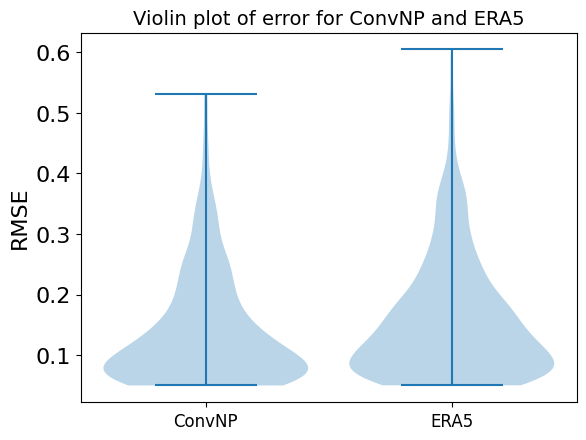

In [42]:
fig, ax = plt.subplots()

era5_diffs = stations_df['era5'] - stations_df[f'{var}_station']
convnp_diffs = stations_df['convnp'] - stations_df[f'{var}_station']
convnp_context_diffs = stations_df['convnp_context'] - stations_df[f'{var}_station']

convnp_diffs= np.array(convnp_diffs.values, dtype=np.float32)
era5_diffs = np.array(era5_diffs.values, dtype=np.float32)
convnp_context_diffs = np.array(convnp_context_diffs.values, dtype=np.float32)

# remove nans
convnp_diffs = convnp_diffs[~np.isnan(convnp_diffs)]
era5_diffs = era5_diffs[~np.isnan(era5_diffs)]
convnp_context_diffs = convnp_context_diffs[~np.isnan(convnp_context_diffs)]

# remove zeros
convnp_diffs = convnp_diffs[convnp_diffs > 0.05]
era5_diffs = era5_diffs[era5_diffs > 0.05]
convnp_context_diffs = convnp_context_diffs[convnp_context_diffs > 0.05]

positions = [1, 1.6]#, 2.2]
ax.violinplot(dataset=[abs(convnp_diffs), 
                       abs(era5_diffs)],
                    #    abs(convnp_context_diffs)], 
                       positions=positions)
ax.tick_params(axis="y", labelsize=16)
ax.set_xticks(positions, labels=["ConvNP", "ERA5"],# "ConvNP-Context"], 
            fontsize=12)
ax.set_ylabel("RMSE", fontsize=16)
ax.set_title("Violin plot of error for ConvNP and ERA5", fontsize=14)




In [ ]:
stations_df['precipitation_station'].max()

37.0